GPUG Meetup (July 2015)
=======================

**Logan Page**

Lecturer

Mechanical and Aeronautical Engineering

University of Pretoria

[Logan.Page at up.ac.za](mailto:Logan.Page at up.ac.za)




Introduction to Cython
======================
"Cython is an optimising static compiler for both the Python programming language and the extended Cython programming language (based on Pyrex). It makes writing C extensions for Python as easy as Python itself." [http://cython.org/](http://cython.org/)
- Write C extention modules with Python syntax and C static declarations (.pxd and .pyx files)
- C code (using the Python C API) is generated once from the .pxd and .pyx files
- Compiled with all major C / C++ compilers

Julia Set Example
-----------------

Compute $ \lim_{\infty} \left| Z_k \right| $ for $ Z_k = Z_{k-1}^2 + C $, $k = 0, 1, 2, \dots$

where $Z$ and $C$ are complex numbers

### Method ###
- Create a 2D grid of pixels
- Compute level $ k $ from $ \lim_{\infty} \left| Z_k \right| $ for each pixel
- Transform the computed values to RGB color values (colormap)
- Display RGB image (matplotlib or PIL)

### Pure Python Version: ###

In [1]:
def core_pure_py(z, c, lim, cutoff):
    """Compute Z_k = Z_{k-1}^2 + C such that |Z_k| < lim"""
    count = 0
    while abs(z) < lim and count < cutoff:
        z = z * z + c
        count += 1
    return count


def pyCompute_pure_py(c, size, bound=2, lim=1000, cutoff=1000):
    """Compute julia set"""
    julia = []
    delta = 2.0 * bound / (size - 1)

    imag = -bound
    for i in xrange(size):
        real = -bound
        row_data = []
        for j in xrange(size):
            z = real + imag * 1j
            z_abs = core_pure_py(z, c, lim, cutoff)
            row_data.append(z_abs)
            real += delta

        imag += delta
        julia.append(row_data)

    return julia

#### Plot Julia Set: ####

In [2]:
import numpy as np
import pylab as plt

TITLE = r"Julia set for $C={0.real:5.3f}+{0.imag:5.3f}i$ $[{1}\times{1}]$"


def plot_julia(c, size, data, bound=2):
    data = np.uint8(plt.cm.gist_earth(data)*255)
    plt.imshow(data, 
               interpolation='nearest',
               extent=(-bound, bound) * 2)

    plt.title(TITLE.format(c, size))
    plt.xlabel(r"$Re(z)$")
    plt.ylabel(r"$Im(z)$")
    plt.show()

1 loops, best of 3: 1.65 s per loop


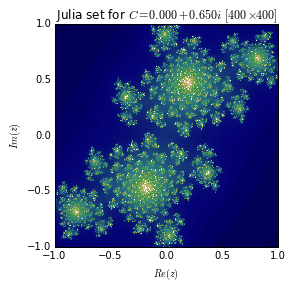

In [3]:
%matplotlib inline
from __main__ import pyCompute_pure_py
from __main__ import plot_julia


N = 400
C = complex(0.0, 0.65)
B = 1.0

%timeit pyCompute_pure_py(C, N, bound=B)
data = pyCompute_pure_py(C, N, bound=B)
plot_julia(C, N, data, bound=B)

### Cython Version (Pure Python Only): ###

In [4]:
import cython
print cython.__version__

0.22.1


In [5]:
%reload_ext cythonmagic

The Cython magic has been moved to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [6]:
%%cython


cdef core_pure_py(z, c, lim, cutoff):
    """Compute |Z_k| > lim, for Z_k = Z_{k-1}^2 + C"""
    count = 0
    while abs(z) < lim and count < cutoff:
        z = z * z + c
        count += 1
    return count


cpdef cyCompute_pure_py(c, size, bound=2, lim=1000, cutoff=1000):
    """Compute julia set"""
    julia = []
    delta = 2.0 * bound / (size - 1)

    imag = -bound
    for i in xrange(size):
        real = -bound
        row_data = []
        for j in xrange(size):
            z = real + imag * 1j
            z_abs = core_pure_py(z, c, lim, cutoff)
            row_data.append(z_abs)
            real += delta

        imag += delta
        julia.append(row_data)

    return julia

**Notes:**
- **%%cython:** Cythonize the file / code (Parse into C code)
- **cimport**: Include other Cython extention modules
- **def**: Python function definition
- **cdef**: C declarations (functions, variables, etc.), **not available in Python-space**
- **cpdef**: C function declaration with Python wrapper overhead

1 loops, best of 3: 766 ms per loop


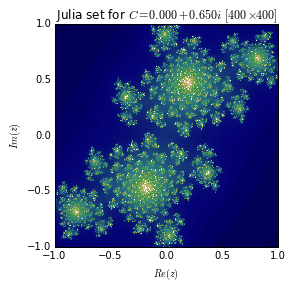

In [7]:
%matplotlib inline
from __main__ import cyCompute_pure_py
from __main__ import plot_julia


N = 400
C = complex(0.0, 0.65)
B = 1.0

%timeit cyCompute_pure_py(C, N, bound=B)
data = cyCompute_pure_py(C, N, bound=B)
plot_julia(C, N, data, bound=B)

### Cython Version (Static Typed Python): ###

In [8]:
%%cython -a


ctypedef unsigned int uint
ctypedef double complex dcplx


cdef uint core_typed(dcplx z, dcplx c, uint lim, uint cutoff):
    """Compute |Z_k| > lim, for Z_k = Z_{k-1}^2 + C"""
    cdef uint count = 0
    while abs(z) < lim and count < cutoff:
        z = z * z + c
        count += 1
    return count


cpdef cyCompute_typed(dcplx c, uint size, double bound=2, uint lim=1000, uint cutoff=1000):
    """Compute julia set"""
    cdef:
        uint i, j, z_abs
        dcplx z
        double imag, real
        double delta = 2.0 * bound / (size - 1)
        list row_data, julia = []

    imag = -bound
    for i in xrange(size):
        real = -bound
        row_data = []
        for j in xrange(size):
            z = real + imag * 1j
            z_abs = core_typed(z, c, lim, cutoff)
            row_data.append(z_abs)
            real += delta

        imag += delta
        julia.append(row_data)

    return julia

**Notes:**
- **%%cython -a:** Cythonize the file / code (Parse into C code) and generate HTML indicating the "typedness":
  - white lines: pure C code
  - yellow lines: C code using Python C API (darker = more C API used)
- **cdef:** Add static typing (C types)

**Bottlenecks:**
- Call to Python abs function for complex numbers
- Python evaluations in while loop
- Type conversion from C Int to Py_Int

1 loops, best of 3: 501 ms per loop


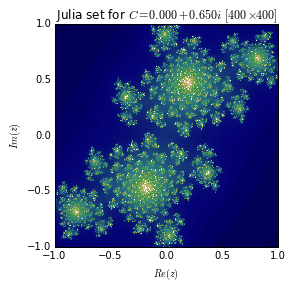

In [9]:
%matplotlib inline
import numpy as np
from __main__ import cyCompute_typed
from __main__ import plot_julia


N = 400
C = complex(0.0, 0.65)
B = 1.0

%timeit cyCompute_typed(C, N, bound=B)
data = np.array(cyCompute_typed(C, N, bound=B), dtype=np.int32)
plot_julia(C, N, data, bound=B)

### Cython Version (Static Typed Python + Optimizations): ###

In [10]:
%%cython -a
cimport cython
cimport numpy as np
import numpy as np


ctypedef unsigned int uint
ctypedef double complex dcplx


cdef extern from "complex.h" nogil:
    double cabs(dcplx z)


cdef uint core_optimized(dcplx z, dcplx c, uint lim, uint cutoff) nogil:
    """Compute |Z_k| > lim, for Z_k = Z_{k-1}^2 + C"""
    cdef uint count = 0
    while cabs(z) < lim and count < cutoff:
        z = z * z + c
        count += 1
    return count


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef cyCompute_optimized(dcplx c, uint size, double bound=2, uint lim=1000, uint cutoff=1000):
    """Compute julia set"""
    cdef:
        uint i, j
        dcplx z
        double imag, real
        double delta = 2.0 * bound / (size - 1)
        np.ndarray julia = np.empty((size, size), dtype=np.int32)
        int[:, :] jview = julia

    imag = -bound
    for i in xrange(size):
        real = -bound
        for j in xrange(size):
            z = real + imag * 1j
            jview[i, j] = core_optimized(z, c, lim, cutoff)
            real += delta

        imag += delta

    return julia

**Notes:**
- **cimport numpy:** Include numpy extentions for Cython
- **import numpy:** Import numpy object for Python
- **cdef extern from:** Include pure C Code (#include "complex.h")
- **nogil:** disable GIL **only for when there are no Python objects (no Python C API)**
- **@cython.boundscheck(False):** disable boundchecking (I.e julia[i, j] where i or j are greater than N, M)
- **@cython.wraparound(False):** disable negative indexing (I.e julia[i, j] where i or j are less than 0, 0)
- **@cython.cdivision(True):** enable C division (disable error checking for div zero)

**Numpy Arrays:**
- Eliminates the type conversion for C Int to Py_Int
- Memoryviews for faster indexing
- Very little gain over lists for this problem case

10 loops, best of 3: 98.1 ms per loop


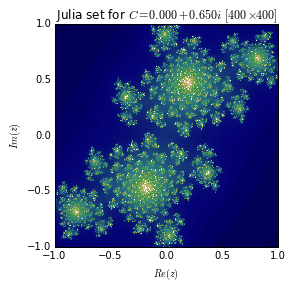

In [11]:
%matplotlib inline
from __main__ import cyCompute_optimized
from __main__ import plot_julia


N = 400
C = complex(0.0, 0.65)
B = 1.0

%timeit cyCompute_optimized(C, N, bound=B)
data = cyCompute_optimized(C, N, bound=B)
plot_julia(C, N, data, bound=B)

### Cython Version (Static Typed Python + Optimizations + OpenMP): ###

In [12]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
cimport cython
cimport numpy as np
import numpy as np

from cython.parallel cimport prange


ctypedef unsigned int uint
ctypedef double complex dcplx


cdef extern from "complex.h" nogil:
    double cabs(dcplx z)


cdef uint core_optimized(dcplx z, dcplx c, uint lim, uint cutoff) nogil:
    """Compute |Z_k| > lim, for Z_k = Z_{k-1}^2 + C"""
    cdef uint count = 0
    while cabs(z) < lim and count < cutoff:
        z = z * z + c
        count += 1
    return count


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef cyCompute_parallel(dcplx c, uint size, double bound=2, uint lim=1000, uint cutoff=1000):
    """Compute julia set"""
    cdef:
        int i, j
        dcplx z
        double real, imag
        double delta = 2.0 * bound / (size - 1)
        np.ndarray julia = np.empty((size, size), dtype=np.int32)
        int[:, :] jview = julia

    for i in prange(size, nogil=True, num_threads=2):
        imag = -<double>bound + i * delta
        for j in xrange(size):
            real = -<double>bound + j * delta
            z = real + imag * 1j
            jview[i, j] = core_optimized(z, c, lim, cutoff)

    return julia

**Notes:**
- **%%cython --compile-args=-fopenmp --link-args=-fopenmp --force:** force OpenMP to work in IPython Notebook
- **< double >:** type cast --> (double)bound
- **for i in prange:** similar to #pragma omp parallel for (in C)

10 loops, best of 3: 50.7 ms per loop


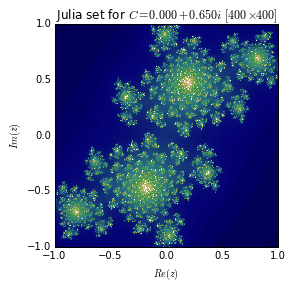

In [13]:
%matplotlib inline
from __main__ import cyCompute_parallel
from __main__ import plot_julia


N = 400
C = complex(0.0, 0.65)
B = 1.0

%timeit cyCompute_parallel(C, N, bound=B)
data = cyCompute_parallel(C, N, bound=B)
plot_julia(C, N, data, bound=B)

### Cython Version (Pure C Code + OpenMP Wrapped): ###

In [18]:
%%cython --compile-args=-fopenmp --include=<path/to/cJulia.c> --link-args=-fopenmp -lm --force

import os

cimport openmp
cimport cython

cimport numpy as np
import numpy as np

from libc.stdlib cimport malloc, free
from cython.parallel cimport prange

ctypedef unsigned int uint
ctypedef double complex dcplx


cdef extern from "cJulia.c" nogil:
    void compute(uint **data, uint size, dcplx c,
                 double bound, uint lim, uint cutoff)


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef cyCompute_pure_c(dcplx c, uint size, double bound=2, uint lim=1000, uint cutoff=1000):
    """Compute julia set"""
    cdef:
        int i, j
        uint **data = NULL
        np.ndarray julia = np.empty((size, size), dtype=np.int32)
        int[:, :] jview = julia
    
    data = <uint**>malloc(size * sizeof(uint*))
    if data == NULL:
        raise MemoryError("Can't create data array!")
    for i in range(size):
        data[i] = <uint*>malloc(size * sizeof(uint))
        if data[i] == NULL:
            raise MemoryError("Can't create data array!")

    compute(data, size, c, bound, lim, cutoff)
    
    for i in prange(size, nogil=True, num_threads=2):
        for j in range(size):
            jview[i, j] = data[i][j]
    
    for i in range(size):
        free(data[i])
    free(data)
    
    return jview

**Notes:**
- **malloc, free:** Allocate and free memory for C arrays

10 loops, best of 3: 50.9 ms per loop


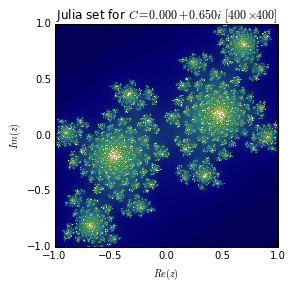

In [19]:
%matplotlib inline
from __main__ import cyCompute_pure_c
from __main__ import plot_julia


N = 400
C = complex(0.0, 0.65)
B = 1.0

%timeit cyCompute_pure_c(C, N, bound=B)
data = cyCompute_pure_c(C, N, bound=B)
plot_julia(C, N, data, bound=B)

### Benchmarks And Timings: ###

In [20]:
from __main__ import pyCompute_pure_py
from __main__ import cyCompute_pure_py
from __main__ import cyCompute_typed
from __main__ import cyCompute_optimized
from __main__ import cyCompute_parallel
from __main__ import cyCompute_pure_c


N = 400
C = complex(0.0, 0.65)
B = 1.0

%timeit pyCompute_pure_py(C, N, bound=B)
%timeit cyCompute_pure_py(C, N, bound=B)
%timeit cyCompute_typed(C, N, bound=B)
%timeit cyCompute_optimized(C, N, bound=B)
%timeit cyCompute_parallel(C, N, bound=B)
%timeit cyCompute_pure_c(C, N, bound=B)

1 loops, best of 3: 1.62 s per loop
1 loops, best of 3: 746 ms per loop
1 loops, best of 3: 498 ms per loop
10 loops, best of 3: 97.6 ms per loop
10 loops, best of 3: 49.1 ms per loop
10 loops, best of 3: 50 ms per loop


**Cython Speedups*:**
- Pure Python: $\approx$ 1.56
- Static Typing: $\approx$ 2.37
- Optimized: $\approx$ 9.82
- Parallel (2 threads): $\approx$ 18.84
- Pure C Wrapped (2 threads): $\approx$ 18.20

*may vary depending on PC specs

### Plot Example Using PIL: ###

In [17]:
from PIL import Image
from pylab import cm
from __main__ import cyCompute_parallel


N = 600
C = complex(0.0, 0.65)
B = 0.8

julia = cyCompute_parallel(C, N, bound=B)
im = Image.fromarray(np.uint8(cm.gist_earth(julia)*255))
im.show()